In [1]:
import os
import random
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn 

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from typing import Tuple

from tqdm import tqdm
from box import Box

from copy import deepcopy

In [2]:
def setSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

# 1. Dataset Preprocessing
    
* Implicit Feedback

In [3]:
class DataInfo():
    def __init__(self, file_path: str) -> None:
        self.df = pd.read_csv(file_path)
        self.user_encoder, self.movie_encoder = self._encode()

        self.users = self.df['userId'].unique()
        self.num_users = len(self.users)
        self.min_feedback = 5 # for resolving cold-start problem
        self.movies = self.df['movieId'].unique()
        self.num_movies = len(self.movies)
        self.train_movies = self._moreThanFeedback()
        self.num_train_movies = len(self.train_movies)

        self.df_pos_user_sequence, self.user_negative_samples = self._makeSequenceAndNeg()

        self.df_pos_train, self.df_pos_test = self._trainTestSplit()
    
    def _trainTestSplit(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        # https://github.com/scikit-learn/scikit-learn/pull/16236
        # GroupTimeSeriesSplit이 PR 중이라고 해서 직접 구현을 해야한다.
        df_train = {
            'user_id': list(),
            'movie_id': list(),
        }

        df_test = {
            'user_id': list(),
            'movie_id': list(),
        }

        for user in self.users:
            df_user = self.df_pos_user_sequence[self.df_pos_user_sequence['user_id']==user]
            list_user_movies = df_user['movie_id'].tolist()

            num_user = df_user.shape[0]
            num_train_user = num_user - 1
            num_test_user = 1

            list_user_train_movies = list_user_movies[:num_train_user]
            list_user_test_movies = list_user_movies[num_train_user:]

            df_train['user_id'].extend([user]*num_train_user)
            df_train['movie_id'].extend(list_user_train_movies)

            df_test['user_id'].extend([user]*num_test_user)
            df_test['movie_id'].extend(list_user_test_movies)
            
        df_train = pd.DataFrame(df_train)
        df_train['label'] = 1

        df_test = pd.DataFrame(df_test)
        df_test['label'] = 1
            
        return df_train, df_test        


    def _moreThanFeedback(self):
        movie_ids_for_training = list()
        for movie_id in self.df['movieId'].unique():
            if self.df[self.df['movieId'] == movie_id].shape[0] >= self.min_feedback:
                movie_ids_for_training.append(movie_id)
        
        return np.unique(movie_ids_for_training)


    def _makeSequenceAndNeg(self):
        pos_user_sequence = {
            'user_id': list(),
            'movie_id': list(),
        }

        user_negative_samples = dict()


        for user in self.users:
            user_sequence_movies = self.df[self.df['userId']==user].sort_values(by='timestamp', axis=0)['movieId'].tolist()
            # 최조 조건을 만족하지 못한 것 포함, feedback있는 영화를 제외시킨다. 
            user_negative_movies = np.setdiff1d(self.movies, np.unique(user_sequence_movies))
            user_negative_samples[user] = user_negative_movies

            for movie in user_sequence_movies:
                # 최소 feedback 조건을 만족시키지 못한 것은 추가하지 않는다.
                if movie not in self.train_movies: continue
                pos_user_sequence['user_id'].append(user)
                pos_user_sequence['movie_id'].append(movie)


        df_pos_user_sequence = pd.DataFrame(pos_user_sequence)
        df_pos_user_sequence['label'] = 1

        return df_pos_user_sequence, user_negative_samples


    def _encode(self) -> Tuple[pd.DataFrame, LabelEncoder, LabelEncoder]:
        userId_label_encoder = LabelEncoder()
        movieId_label_encoder = LabelEncoder()

        self.df['userId'] = userId_label_encoder.fit_transform(self.df['userId'].values)
        self.df['movieId'] = movieId_label_encoder.fit_transform(self.df['movieId'].values)

        # encoder.inverse_transform() 으로 decode
        return userId_label_encoder, movieId_label_encoder

In [4]:
class NeuMFDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df
            
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        user = self.df.iloc[idx]['user_id']
        item = self.df.iloc[idx]['movie_id']
        label = self.df.iloc[idx]['label']
        
        return torch.tensor(user).to(torch.int64), torch.tensor(item).to(torch.int64), torch.tensor(label).float()

# 2. Model

In [5]:
class GMF(nn.Module):
    def __init__(self, num_users: int, num_items: int, latent_dim: int):
        super(GMF, self).__init__()

        self.embedding_user = nn.Embedding(num_users, latent_dim)
        self.embedding_item = nn.Embedding(num_items, latent_dim)

        self.prediction = nn.Sequential(
            nn.Linear(latent_dim, 1, bias=False),
            nn.Sigmoid()
        )

        self._init_weights()
    
    def _init_weights(self):
        for module in self.modules():
            # print(module.__class__.__name__)
            if isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight.data, mean=0.0, std=0.01)
            elif isinstance(module, nn.Linear):
                nn.init.normal_(module.weight.data, 0, 0.01)
                if module.bias is not None:
                    module.bias.data.fill_(0.0)

    
    def forward(self, user_input, item_input):

        user_latent = self.embedding_user(user_input)
        item_latent = self.embedding_item(item_input)
        product = user_latent * item_latent

        output = self.prediction(product)

        return output.squeeze()

In [40]:
class MLP(nn.Module):
    def __init__(self, num_uesrs, num_items, latent_dim, dropout, layers=[20, 10]):
        super(MLP, self).__init__()

        self.embedding_user = nn.Embedding(num_uesrs, latent_dim)
        self.embedding_item = nn.Embedding(num_items, latent_dim)

        self.layers = deepcopy(layers)
        self.layers.insert(0, latent_dim * 2)
        modules = []
        for i in range(len(self.layers) - 1):
            modules.append(nn.Dropout(p=dropout))
            modules.append(nn.Linear(self.layers[i], self.layers[i+1]))
            modules.append(nn.ReLU())
        
        self.dense_layers = nn.Sequential(*modules)

        self.prediction = nn.Sequential(
            nn.Linear(layers[-1], 1, bias=False),
            nn.Sigmoid()
        )

        self._init_weights()
    
    # initialize weights
    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight.data, mean=0.0, std=0.01)
            elif isinstance(module, nn.Linear):
                nn.init.normal_(module.weight.data, 0, 0.01)
                if module.bias is not None:
                    module.bias.data.fill_(0.0)

    def forward(self, user_input, item_input):
        user_latent = self.embedding_user(user_input)
        item_latent = self.embedding_item(item_input)

        vector = torch.cat((user_latent, item_latent), dim=-1)

        output = self.prediction(self.dense_layers(vector))

        return output.squeeze()

In [7]:
class NeuMF(nn.Module):
    def __init__(self, GMF, MLP, latent_dim, layers):
        super(NeuMF, self).__init__()

        self.GMF_embedding_user = deepcopy(GMF.embedding_user)
        self.GMF_embedding_item = deepcopy(GMF.embedding_item)

        self.MLP_embedding_user = deepcopy(MLP.embedding_user)
        self.MLP_embedding_item = deepcopy(MLP.embedding_item)

        self.MLP_dense_layers = deepcopy(MLP.dense_layers)

        self.prediction = nn.Sequential(
            nn.Linear(latent_dim + layers[-1], 1, bias=False),
            nn.Sigmoid()
        )
        
        self._init_weights()
    
    # initialize weights
    def _init_weights(self):
        for module in self.prediction.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight.data, mean=0.0, std=0.01)
                if module.bias is not None:
                    module.bias.data.fill_(0.0)

    def forward(self, user_input, item_input):

        GMF_user_latent = self.GMF_embedding_user(user_input)
        GMF_item_latent = self.GMF_embedding_item(item_input)
        GMF_output = GMF_user_latent * GMF_item_latent

        MLP_user_latent = self.MLP_embedding_user(user_input)
        MLP_item_latent = self.MLP_embedding_item(item_input)
        vector = torch.cat((MLP_user_latent, MLP_item_latent), dim=-1)
        MLP_output = self.MLP_dense_layers(vector)

        concat_output = torch.cat((GMF_output, MLP_output), dim=-1)
        output = self.prediction(concat_output)

        return output.squeeze()


# 3. Train, Metric 함수

In [8]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, test_loader, epochs, criterion, device, neg_smaples, num_neg, topK, output_path, name):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.epochs = epochs
        self.criterion = criterion
        self.device = device
        self.neg_samples = neg_smaples
        self.num_neg = num_neg
        self.topK = topK

        self.loss_list = []
        self.hr_list = []
        self.ndcg_list = []

        self.output_path = output_path
        self.model_name = name
        
        self._train_metric()
    

    def _train_metric(self):
        
        best_ndcg = 0
        # 훈련 시간 측정
        epoch_start = torch.cuda.Event(enable_timing=True)
        epoch_end = torch.cuda.Event(enable_timing=True)
        
        for epoch in range(self.epochs):
            # 시작 시간 기록
            epoch_start.record()

            avg_loss = self._train()
            avg_hr, avg_ndcg = self._metric()
        
            epoch_end.record()
            torch.cuda.synchronize()

            self.loss_list.append(avg_loss)
            self.hr_list.append(avg_hr)
            self.ndcg_list.append(avg_ndcg)


            print(
                f'Epoch[{epoch+1}/{self.epochs}]\ttrain_loss: {avg_loss:.4f}' +
                f'\tHR: {avg_hr:.4f}\tNDCG: {avg_ndcg:.4f} '+
                f'\t훈련시간: {epoch_start.elapsed_time(epoch_end)/1000:.2f} sec'
            )

            if best_ndcg < avg_ndcg:
                best_ndcg = avg_ndcg
                torch.save(self.model.state_dict(), os.path.join(self.output_path, f'best_NDCG_{self.model_name}.pt'))
                print(f'save ndcg: {best_ndcg:.4f}')

    
    def _train(self):
        self.model.train()

        size = len(self.train_loader)
        epoch_loss = 0

        for user, item, label in tqdm(self.train_loader):
            user = user.to(self.device)
            item = item.to(self.device)
            label = label.to(self.device)

            user_neg, item_neg, label_neg = self._negative_sampling(user, self.num_neg)
            input_user, input_item, input_label = self._concat(user, user_neg, item, item_neg, label, label_neg)

            self.optimizer.zero_grad()

            output = self.model(input_user, input_item)

            loss = self.criterion(output, input_label)
            loss.backward()
            self.optimizer.step()
            
            epoch_loss += loss.item()


        avg_loss = epoch_loss / size

        return avg_loss

    def _metric(self):
        self.model.eval()

        size = len(self.test_loader)

        epoch_hr = 0
        epoch_ndcg = 0

        with torch.no_grad():
            for user, item, label in self.test_loader:
                user = user.to(self.device)
                item = item.to(self.device)
                label = label.to(self.device).float()

                user_neg, item_neg, label_neg = self._negative_sampling(user, 100)
                input_user, input_item, input_label = self._concat(user, user_neg, item, item_neg, label, label_neg)

                output = self.model(input_user, input_item)
                _, indices = torch.topk(output, dim=0, k=self.topK)
                rank_list = torch.take(input_item, indices).cpu().numpy().tolist()
                target_item = item.cpu().numpy()[0]

                epoch_hr += self._get_hit_ratio(rank_list, target_item)
                epoch_ndcg += self._get_NDCG(rank_list, target_item)
        
        avg_hr = epoch_hr / size
        avg_ndcg = epoch_ndcg / size

        return avg_hr, avg_ndcg

    
    def _get_hit_ratio(self, rank_list, target_item):
        for item in rank_list:
            if item == target_item:
                return 1
        return 0


    def _get_NDCG(self, rank_list, target_item):
        for i in range(len(rank_list)):
            item = rank_list[i]
            if item == target_item:
                return np.log(2) / np.log(i+2)
        return 0
            
    def _negative_sampling(self, users, num_neg):
        user_neg, item_neg, label_neg = [], [], []

        users = users.detach().cpu().numpy()
        for user in users:
            items = np.random.choice(self.neg_samples[user], min(len(self.neg_samples), num_neg), replace=False)
            for item in items:
                user_neg.append(user)
                item_neg.append(item)
                label_neg.append(0)

        
        return (
            torch.tensor(user_neg).to(torch.int64).to(self.device), 
            torch.tensor(item_neg).to(torch.int64).to(self.device), 
            torch.tensor(label_neg).to(self.device).float()
        )


    def _concat(self, user, user_neg, item, item_neg, label, label_neg):
        input_user = torch.cat([user, user_neg], dim=0)
        input_item = torch.cat([item, item_neg], dim=0)
        input_label = torch.cat([label, label_neg], dim=0)

        return  input_user, input_item, input_label


# 4. 훈련

## 4.1. 환경 설정 및 hyper parameter 설정

In [9]:
dir_base = os.path.join(os.path.join('/opt','ml','paper','RecSys'))
dir_data = os.path.join(dir_base, 'Data', 'ml-latest-small')
path_rating = os.path.join(dir_data, 'ratings.csv')
dir_output = os.path.join(os.getcwd(), 'output')
dir_file_path = {
    'dir_base': dir_base,
    'dir_data': dir_data,
    'rating': path_rating,
    'dir_output': dir_output,
}

path = Box(dir_file_path)

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Use {device}')

# 해당 논문의 github에서 사용한 값 참고
config = {
    'seed': 42,
    'device': device,
    }

config = Box(config)

hyper = {
    'batch_size': 256,
    'epochs': 40,
    'pretrain_epochs': 20,
    'latent_dim': 8,
    'num_neg': 3,
    'lr': 0.001,
    'optimizer': 'adam',
    'criterion': 'BCE',
    'layers': [16, 8, 4],
    'dropout': 0.2,
    'topK': 10,
    'num_neg': 4,
}

hyper = Box(hyper)

Use cuda


In [11]:
setSeed(config.seed)
data = DataInfo(path.rating)

torch.cuda.empty_cache() # if necessary

train_dataset = NeuMFDataset(data.df_pos_train)
train_loader = DataLoader(train_dataset, batch_size=hyper.batch_size, shuffle=True, drop_last=False)

test_dataset = NeuMFDataset(data.df_pos_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

criterion = nn.BCELoss()

## 4.2. GMF 훈련

In [12]:
GMF_model = GMF(data.num_users, data.num_movies, hyper.latent_dim)
GMF_model.to(config.device)
GMF_optimizer = torch.optim.Adam(GMF_model.parameters(), lr=hyper.lr)

GMF_trainer = Trainer(GMF_model, GMF_optimizer, train_loader, test_loader, hyper.epochs, criterion, config.device, data.user_negative_samples, hyper.num_neg, hyper.topK, path.dir_output, 'GMF')

  0%|          | 1/351 [00:00<00:53,  6.56it/s]

Epoch[1/40]	train_loss: 0.6758	HR: 0.6213	NDCG: 0.3609 	훈련시간: 50.17 sec
save ndcg: 0.3609


  0%|          | 1/351 [00:00<01:07,  5.22it/s]

Epoch[2/40]	train_loss: 0.4483	HR: 0.6082	NDCG: 0.3519 	훈련시간: 49.75 sec


  0%|          | 1/351 [00:00<00:47,  7.35it/s]

Epoch[3/40]	train_loss: 0.3072	HR: 0.6361	NDCG: 0.3589 	훈련시간: 47.48 sec


  0%|          | 1/351 [00:00<00:55,  6.31it/s]

Epoch[4/40]	train_loss: 0.2788	HR: 0.6377	NDCG: 0.3654 	훈련시간: 47.99 sec
save ndcg: 0.3654


  0%|          | 1/351 [00:00<00:46,  7.47it/s]

Epoch[5/40]	train_loss: 0.2689	HR: 0.6508	NDCG: 0.3740 	훈련시간: 47.38 sec
save ndcg: 0.3740


  0%|          | 1/351 [00:00<01:09,  5.07it/s]

Epoch[6/40]	train_loss: 0.2623	HR: 0.6344	NDCG: 0.3702 	훈련시간: 47.54 sec


  0%|          | 1/351 [00:00<01:06,  5.27it/s]

Epoch[7/40]	train_loss: 0.2593	HR: 0.6262	NDCG: 0.3709 	훈련시간: 47.19 sec


  0%|          | 1/351 [00:00<00:50,  6.98it/s]

Epoch[8/40]	train_loss: 0.2571	HR: 0.6262	NDCG: 0.3619 	훈련시간: 47.50 sec


  0%|          | 1/351 [00:00<00:49,  7.03it/s]

Epoch[9/40]	train_loss: 0.2555	HR: 0.6361	NDCG: 0.3628 	훈련시간: 47.39 sec


  0%|          | 1/351 [00:00<00:49,  7.13it/s]

Epoch[10/40]	train_loss: 0.2539	HR: 0.6344	NDCG: 0.3753 	훈련시간: 46.99 sec
save ndcg: 0.3753


  0%|          | 1/351 [00:00<01:05,  5.37it/s]

Epoch[11/40]	train_loss: 0.2531	HR: 0.6344	NDCG: 0.3705 	훈련시간: 47.31 sec


  0%|          | 1/351 [00:00<00:48,  7.15it/s]

Epoch[12/40]	train_loss: 0.2515	HR: 0.6361	NDCG: 0.3757 	훈련시간: 47.25 sec
save ndcg: 0.3757


  0%|          | 1/351 [00:00<01:05,  5.34it/s]

Epoch[13/40]	train_loss: 0.2481	HR: 0.6492	NDCG: 0.3807 	훈련시간: 47.36 sec
save ndcg: 0.3807


  0%|          | 1/351 [00:00<00:48,  7.23it/s]

Epoch[14/40]	train_loss: 0.2443	HR: 0.6525	NDCG: 0.3890 	훈련시간: 46.93 sec
save ndcg: 0.3890


  0%|          | 1/351 [00:00<00:54,  6.37it/s]

Epoch[15/40]	train_loss: 0.2403	HR: 0.6574	NDCG: 0.3958 	훈련시간: 47.42 sec
save ndcg: 0.3958


  0%|          | 0/351 [00:00<?, ?it/s]

Epoch[16/40]	train_loss: 0.2335	HR: 0.6623	NDCG: 0.3975 	훈련시간: 47.43 sec
save ndcg: 0.3975


  0%|          | 0/351 [00:00<?, ?it/s]

Epoch[17/40]	train_loss: 0.2263	HR: 0.6803	NDCG: 0.4146 	훈련시간: 47.30 sec
save ndcg: 0.4146


  0%|          | 0/351 [00:00<?, ?it/s]

Epoch[18/40]	train_loss: 0.2182	HR: 0.6803	NDCG: 0.4077 	훈련시간: 46.89 sec


  0%|          | 1/351 [00:00<00:48,  7.26it/s]

Epoch[19/40]	train_loss: 0.2129	HR: 0.6934	NDCG: 0.4249 	훈련시간: 47.67 sec
save ndcg: 0.4249


  0%|          | 1/351 [00:00<00:58,  6.03it/s]

Epoch[20/40]	train_loss: 0.2074	HR: 0.7115	NDCG: 0.4340 	훈련시간: 47.64 sec
save ndcg: 0.4340


  0%|          | 1/351 [00:00<00:55,  6.30it/s]

Epoch[21/40]	train_loss: 0.2031	HR: 0.7246	NDCG: 0.4427 	훈련시간: 48.06 sec
save ndcg: 0.4427


  0%|          | 1/351 [00:00<00:49,  7.13it/s]

Epoch[22/40]	train_loss: 0.1993	HR: 0.7131	NDCG: 0.4422 	훈련시간: 47.18 sec


  0%|          | 1/351 [00:00<00:55,  6.35it/s]

Epoch[23/40]	train_loss: 0.1946	HR: 0.7246	NDCG: 0.4397 	훈련시간: 47.04 sec


  0%|          | 0/351 [00:00<?, ?it/s]

Epoch[24/40]	train_loss: 0.1906	HR: 0.7508	NDCG: 0.4659 	훈련시간: 47.28 sec
save ndcg: 0.4659


  0%|          | 1/351 [00:00<00:52,  6.65it/s]

Epoch[25/40]	train_loss: 0.1857	HR: 0.7525	NDCG: 0.4748 	훈련시간: 47.16 sec
save ndcg: 0.4748


  0%|          | 1/351 [00:00<01:03,  5.49it/s]

Epoch[26/40]	train_loss: 0.1820	HR: 0.7623	NDCG: 0.4824 	훈련시간: 47.24 sec
save ndcg: 0.4824


  0%|          | 1/351 [00:00<00:51,  6.79it/s]

Epoch[27/40]	train_loss: 0.1792	HR: 0.7541	NDCG: 0.4717 	훈련시간: 47.14 sec


  0%|          | 0/351 [00:00<?, ?it/s]

Epoch[28/40]	train_loss: 0.1764	HR: 0.7525	NDCG: 0.4749 	훈련시간: 47.37 sec


  0%|          | 1/351 [00:00<00:53,  6.52it/s]

Epoch[29/40]	train_loss: 0.1732	HR: 0.7705	NDCG: 0.4932 	훈련시간: 47.45 sec
save ndcg: 0.4932


  0%|          | 1/351 [00:00<00:49,  7.02it/s]

Epoch[30/40]	train_loss: 0.1706	HR: 0.7820	NDCG: 0.4851 	훈련시간: 47.19 sec


  0%|          | 1/351 [00:00<00:52,  6.65it/s]

Epoch[31/40]	train_loss: 0.1685	HR: 0.7803	NDCG: 0.4880 	훈련시간: 47.46 sec


  0%|          | 1/351 [00:00<00:48,  7.23it/s]

Epoch[32/40]	train_loss: 0.1663	HR: 0.7689	NDCG: 0.5001 	훈련시간: 47.21 sec
save ndcg: 0.5001


  0%|          | 1/351 [00:00<01:06,  5.29it/s]

Epoch[33/40]	train_loss: 0.1653	HR: 0.7836	NDCG: 0.5041 	훈련시간: 47.35 sec
save ndcg: 0.5041


  0%|          | 1/351 [00:00<00:50,  6.92it/s]

Epoch[34/40]	train_loss: 0.1629	HR: 0.7689	NDCG: 0.4841 	훈련시간: 47.56 sec


  0%|          | 0/351 [00:00<?, ?it/s]

Epoch[35/40]	train_loss: 0.1615	HR: 0.7984	NDCG: 0.4887 	훈련시간: 47.58 sec


  0%|          | 1/351 [00:00<01:02,  5.56it/s]

Epoch[36/40]	train_loss: 0.1609	HR: 0.7836	NDCG: 0.5040 	훈련시간: 47.28 sec


  0%|          | 1/351 [00:00<00:50,  6.98it/s]

Epoch[37/40]	train_loss: 0.1595	HR: 0.7820	NDCG: 0.5012 	훈련시간: 47.40 sec


  0%|          | 0/351 [00:00<?, ?it/s]

Epoch[38/40]	train_loss: 0.1586	HR: 0.7951	NDCG: 0.5107 	훈련시간: 49.73 sec
save ndcg: 0.5107


  0%|          | 1/351 [00:00<00:49,  7.06it/s]

Epoch[39/40]	train_loss: 0.1577	HR: 0.7885	NDCG: 0.5066 	훈련시간: 47.20 sec


100%|██████████| 351/351 [00:45<00:00,  7.63it/s]


Epoch[40/40]	train_loss: 0.1565	HR: 0.7918	NDCG: 0.5075 	훈련시간: 46.88 sec


## 4.3. MLP 훈련

In [44]:
MLP_model = MLP(data.num_users, data.num_movies, hyper.latent_dim, hyper.dropout, hyper.layers)
MLP_model.to(config.device)
MLP_optimizer = torch.optim.Adam(MLP_model.parameters(), lr=hyper.lr)

MLP_trainer = Trainer(MLP_model, MLP_optimizer, train_loader, test_loader, hyper.epochs, criterion, config.device, data.user_negative_samples, hyper.num_neg, hyper.topK, path.dir_output, 'MLP')

  0%|          | 1/351 [00:00<01:01,  5.67it/s]

Epoch[1/40]	train_loss: 0.4960	HR: 0.6738	NDCG: 0.2701 	훈련시간: 47.90 sec
save ndcg: 0.2701


  0%|          | 1/351 [00:00<01:02,  5.62it/s]

Epoch[2/40]	train_loss: 0.3012	HR: 0.6656	NDCG: 0.2650 	훈련시간: 47.42 sec


  0%|          | 0/351 [00:00<?, ?it/s]

Epoch[3/40]	train_loss: 0.2863	HR: 0.6541	NDCG: 0.3063 	훈련시간: 47.43 sec
save ndcg: 0.3063


  0%|          | 1/351 [00:00<00:58,  5.99it/s]

Epoch[4/40]	train_loss: 0.2824	HR: 0.6525	NDCG: 0.2937 	훈련시간: 47.38 sec


  0%|          | 1/351 [00:00<00:53,  6.59it/s]

Epoch[5/40]	train_loss: 0.2805	HR: 0.6623	NDCG: 0.2853 	훈련시간: 47.79 sec


  0%|          | 1/351 [00:00<01:06,  5.24it/s]

Epoch[6/40]	train_loss: 0.2797	HR: 0.6590	NDCG: 0.2913 	훈련시간: 47.25 sec


  0%|          | 1/351 [00:00<00:59,  5.90it/s]

Epoch[7/40]	train_loss: 0.2788	HR: 0.6656	NDCG: 0.3016 	훈련시간: 47.68 sec


  0%|          | 1/351 [00:00<00:52,  6.73it/s]

Epoch[8/40]	train_loss: 0.2783	HR: 0.6639	NDCG: 0.2984 	훈련시간: 47.19 sec


  0%|          | 1/351 [00:00<01:08,  5.12it/s]

Epoch[9/40]	train_loss: 0.2782	HR: 0.6475	NDCG: 0.3072 	훈련시간: 47.64 sec
save ndcg: 0.3072


  0%|          | 1/351 [00:00<00:47,  7.30it/s]

Epoch[10/40]	train_loss: 0.2782	HR: 0.6590	NDCG: 0.3037 	훈련시간: 47.20 sec


  0%|          | 1/351 [00:00<00:54,  6.44it/s]

Epoch[11/40]	train_loss: 0.2776	HR: 0.6508	NDCG: 0.2970 	훈련시간: 47.39 sec


  0%|          | 1/351 [00:00<00:48,  7.16it/s]

Epoch[12/40]	train_loss: 0.2777	HR: 0.6607	NDCG: 0.2907 	훈련시간: 47.26 sec


  0%|          | 1/351 [00:00<00:54,  6.40it/s]

Epoch[13/40]	train_loss: 0.2768	HR: 0.6623	NDCG: 0.3064 	훈련시간: 47.51 sec


  0%|          | 1/351 [00:00<01:07,  5.16it/s]

Epoch[14/40]	train_loss: 0.2771	HR: 0.6508	NDCG: 0.3084 	훈련시간: 47.94 sec
save ndcg: 0.3084


  0%|          | 1/351 [00:00<00:48,  7.26it/s]

Epoch[15/40]	train_loss: 0.2765	HR: 0.6623	NDCG: 0.3071 	훈련시간: 47.34 sec


  0%|          | 0/351 [00:00<?, ?it/s]

Epoch[16/40]	train_loss: 0.2763	HR: 0.6590	NDCG: 0.3063 	훈련시간: 47.97 sec


  0%|          | 1/351 [00:00<01:03,  5.53it/s]

Epoch[17/40]	train_loss: 0.2764	HR: 0.6541	NDCG: 0.3014 	훈련시간: 47.68 sec


  0%|          | 0/351 [00:00<?, ?it/s]

Epoch[18/40]	train_loss: 0.2764	HR: 0.6541	NDCG: 0.3038 	훈련시간: 47.57 sec


  0%|          | 1/351 [00:00<00:55,  6.34it/s]

Epoch[19/40]	train_loss: 0.2762	HR: 0.6590	NDCG: 0.2979 	훈련시간: 47.35 sec


  0%|          | 0/351 [00:00<?, ?it/s]

Epoch[20/40]	train_loss: 0.2760	HR: 0.6623	NDCG: 0.3040 	훈련시간: 47.21 sec


  0%|          | 1/351 [00:00<00:48,  7.26it/s]

Epoch[21/40]	train_loss: 0.2757	HR: 0.6607	NDCG: 0.3040 	훈련시간: 47.15 sec


  0%|          | 1/351 [00:00<00:54,  6.39it/s]

Epoch[22/40]	train_loss: 0.2765	HR: 0.6820	NDCG: 0.3169 	훈련시간: 48.52 sec
save ndcg: 0.3169


  0%|          | 1/351 [00:00<00:47,  7.44it/s]

Epoch[23/40]	train_loss: 0.2765	HR: 0.6705	NDCG: 0.3173 	훈련시간: 47.34 sec
save ndcg: 0.3173


  0%|          | 1/351 [00:00<01:04,  5.43it/s]

Epoch[24/40]	train_loss: 0.2760	HR: 0.6590	NDCG: 0.3161 	훈련시간: 47.22 sec


  0%|          | 0/351 [00:00<?, ?it/s]

Epoch[25/40]	train_loss: 0.2753	HR: 0.6721	NDCG: 0.3176 	훈련시간: 47.33 sec
save ndcg: 0.3176


  0%|          | 1/351 [00:00<00:47,  7.34it/s]

Epoch[26/40]	train_loss: 0.2749	HR: 0.6590	NDCG: 0.3069 	훈련시간: 46.94 sec


  0%|          | 1/351 [00:00<01:04,  5.39it/s]

Epoch[27/40]	train_loss: 0.2749	HR: 0.6820	NDCG: 0.3187 	훈련시간: 47.52 sec
save ndcg: 0.3187


  0%|          | 1/351 [00:00<01:06,  5.24it/s]

Epoch[28/40]	train_loss: 0.2748	HR: 0.6623	NDCG: 0.3075 	훈련시간: 47.29 sec


  0%|          | 1/351 [00:00<00:55,  6.34it/s]

Epoch[29/40]	train_loss: 0.2744	HR: 0.6672	NDCG: 0.2961 	훈련시간: 47.77 sec


  0%|          | 1/351 [00:00<00:48,  7.19it/s]

Epoch[30/40]	train_loss: 0.2742	HR: 0.6705	NDCG: 0.3023 	훈련시간: 47.27 sec


  0%|          | 1/351 [00:00<01:02,  5.56it/s]

Epoch[31/40]	train_loss: 0.2742	HR: 0.6656	NDCG: 0.2993 	훈련시간: 47.47 sec


  0%|          | 1/351 [00:00<01:08,  5.09it/s]

Epoch[32/40]	train_loss: 0.2741	HR: 0.6738	NDCG: 0.3151 	훈련시간: 47.39 sec


  0%|          | 1/351 [00:00<00:51,  6.82it/s]

Epoch[33/40]	train_loss: 0.2732	HR: 0.6689	NDCG: 0.3031 	훈련시간: 47.19 sec


  0%|          | 1/351 [00:00<00:47,  7.39it/s]

Epoch[34/40]	train_loss: 0.2725	HR: 0.6803	NDCG: 0.3076 	훈련시간: 46.95 sec


  0%|          | 1/351 [00:00<00:54,  6.44it/s]

Epoch[35/40]	train_loss: 0.2720	HR: 0.6705	NDCG: 0.3115 	훈련시간: 47.38 sec


  0%|          | 1/351 [00:00<00:53,  6.57it/s]

Epoch[36/40]	train_loss: 0.2716	HR: 0.6836	NDCG: 0.3067 	훈련시간: 47.08 sec


  0%|          | 1/351 [00:00<00:45,  7.66it/s]

Epoch[37/40]	train_loss: 0.2710	HR: 0.6951	NDCG: 0.2985 	훈련시간: 47.54 sec


  0%|          | 1/351 [00:00<00:47,  7.35it/s]

Epoch[38/40]	train_loss: 0.2700	HR: 0.6934	NDCG: 0.3084 	훈련시간: 46.88 sec


  0%|          | 1/351 [00:00<01:01,  5.71it/s]

Epoch[39/40]	train_loss: 0.2687	HR: 0.6885	NDCG: 0.3131 	훈련시간: 47.12 sec


100%|██████████| 351/351 [00:44<00:00,  7.90it/s]


Epoch[40/40]	train_loss: 0.2675	HR: 0.7131	NDCG: 0.3083 	훈련시간: 45.42 sec


## 4.4. NeuMF 훈련

In [45]:
best_GMF_model = GMF(data.num_users, data.num_movies, hyper.latent_dim)
best_GMF_model.load_state_dict(torch.load(os.path.join(path.dir_output, 'best_NDCG_GMF.pt')))

best_MLP_model = MLP(data.num_users, data.num_movies, hyper.latent_dim, hyper.dropout, hyper.layers)
best_MLP_model.load_state_dict(torch.load(os.path.join(path.dir_output, 'best_NDCG_MLP.pt')))

NeuMF_model = NeuMF(best_GMF_model, best_MLP_model, hyper.latent_dim, hyper.layers)
NeuMF_model.to(config.device)
NeuMF_optimizer = torch.optim.Adam(NeuMF_model.parameters(), lr=hyper.lr)

NeuMF_trainer = Trainer(NeuMF_model, NeuMF_optimizer, train_loader, test_loader, hyper.pretrain_epochs, criterion, config.device, data.user_negative_samples, hyper.num_neg, hyper.topK, path.dir_output, 'NeuMF')

  0%|          | 0/351 [00:00<?, ?it/s]

Epoch[1/20]	train_loss: 0.2945	HR: 0.6525	NDCG: 0.4253 	훈련시간: 45.28 sec
save ndcg: 0.4253


  0%|          | 1/351 [00:00<00:48,  7.26it/s]

Epoch[2/20]	train_loss: 0.2390	HR: 0.7000	NDCG: 0.4395 	훈련시간: 45.21 sec
save ndcg: 0.4395


  0%|          | 1/351 [00:00<00:44,  7.79it/s]

Epoch[3/20]	train_loss: 0.2051	HR: 0.7262	NDCG: 0.4481 	훈련시간: 45.15 sec
save ndcg: 0.4481


  0%|          | 1/351 [00:00<00:49,  7.08it/s]

Epoch[4/20]	train_loss: 0.1875	HR: 0.7508	NDCG: 0.4674 	훈련시간: 45.11 sec
save ndcg: 0.4674


  0%|          | 1/351 [00:00<00:48,  7.29it/s]

Epoch[5/20]	train_loss: 0.1771	HR: 0.7787	NDCG: 0.4898 	훈련시간: 45.19 sec
save ndcg: 0.4898


  0%|          | 1/351 [00:00<00:45,  7.77it/s]

Epoch[6/20]	train_loss: 0.1709	HR: 0.7852	NDCG: 0.4991 	훈련시간: 45.09 sec
save ndcg: 0.4991


  0%|          | 0/351 [00:00<?, ?it/s]

Epoch[7/20]	train_loss: 0.1655	HR: 0.7869	NDCG: 0.5016 	훈련시간: 52.14 sec
save ndcg: 0.5016


  0%|          | 0/351 [00:00<?, ?it/s]

Epoch[8/20]	train_loss: 0.1623	HR: 0.7885	NDCG: 0.5006 	훈련시간: 52.15 sec


  0%|          | 0/351 [00:00<?, ?it/s]

Epoch[9/20]	train_loss: 0.1597	HR: 0.7869	NDCG: 0.5103 	훈련시간: 47.75 sec
save ndcg: 0.5103


  0%|          | 1/351 [00:00<00:58,  5.95it/s]

Epoch[10/20]	train_loss: 0.1582	HR: 0.7902	NDCG: 0.5008 	훈련시간: 47.93 sec


  0%|          | 0/351 [00:00<?, ?it/s]

Epoch[11/20]	train_loss: 0.1564	HR: 0.7984	NDCG: 0.5068 	훈련시간: 47.86 sec


  0%|          | 0/351 [00:00<?, ?it/s]

Epoch[12/20]	train_loss: 0.1557	HR: 0.8033	NDCG: 0.5166 	훈련시간: 47.96 sec
save ndcg: 0.5166


  0%|          | 0/351 [00:00<?, ?it/s]

Epoch[13/20]	train_loss: 0.1539	HR: 0.8033	NDCG: 0.5226 	훈련시간: 47.79 sec
save ndcg: 0.5226


  0%|          | 1/351 [00:00<01:07,  5.16it/s]

Epoch[14/20]	train_loss: 0.1531	HR: 0.7951	NDCG: 0.5124 	훈련시간: 48.11 sec


  0%|          | 1/351 [00:00<01:02,  5.57it/s]

Epoch[15/20]	train_loss: 0.1518	HR: 0.7934	NDCG: 0.5141 	훈련시간: 47.58 sec


  0%|          | 1/351 [00:00<01:04,  5.43it/s]

Epoch[16/20]	train_loss: 0.1516	HR: 0.8016	NDCG: 0.5199 	훈련시간: 47.46 sec


  0%|          | 0/351 [00:00<?, ?it/s]

Epoch[17/20]	train_loss: 0.1501	HR: 0.7967	NDCG: 0.5152 	훈련시간: 47.35 sec


  0%|          | 1/351 [00:00<00:56,  6.18it/s]

Epoch[18/20]	train_loss: 0.1496	HR: 0.8049	NDCG: 0.5115 	훈련시간: 48.04 sec


  0%|          | 1/351 [00:00<00:49,  7.03it/s]

Epoch[19/20]	train_loss: 0.1496	HR: 0.7836	NDCG: 0.5114 	훈련시간: 47.46 sec


100%|██████████| 351/351 [00:46<00:00,  7.52it/s]


Epoch[20/20]	train_loss: 0.1489	HR: 0.8148	NDCG: 0.5272 	훈련시간: 47.77 sec
save ndcg: 0.5272


# 5. Plot loss, hr, ndcg

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 0.98, 'NeuMF')

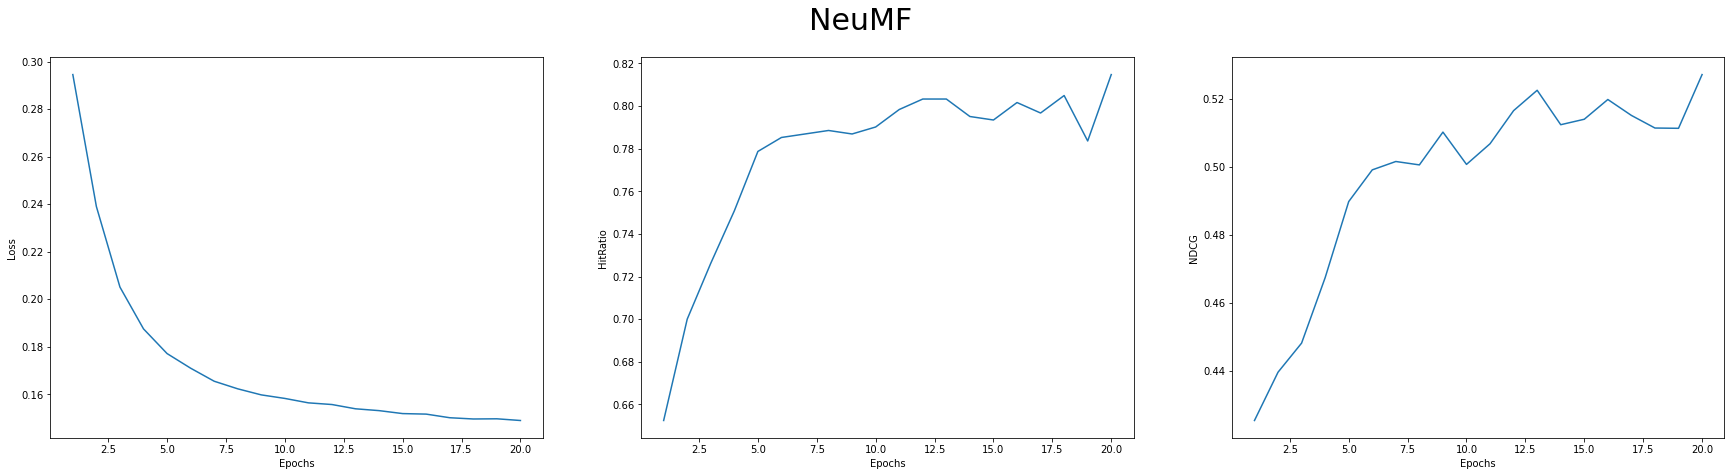

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(30, 7))
x_list = [i for i in range(1, hyper.pretrain_epochs+1)]

sns.lineplot(
    x=x_list, y=NeuMF_trainer.loss_list,
    ax = axes[0]
)

axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epochs')

sns.lineplot(
    x=x_list, y=NeuMF_trainer.hr_list,
    ax=axes[1]
)

axes[1].set_ylabel('HitRatio')
axes[1].set_xlabel('Epochs')

sns.lineplot(
    x=x_list, y=NeuMF_trainer.ndcg_list,
    ax=axes[2]
)

axes[2].set_ylabel('NDCG')
axes[2].set_xlabel('Epochs')

fig.suptitle('NeuMF', fontsize=30)

# 6. Inference

In [48]:
# model load

best_model = NeuMF(GMF_model, MLP_model, hyper.latent_dim, hyper.layers)
best_model.load_state_dict(torch.load(os.path.join(path.dir_output, 'best_NDCG_NeuMF.pt')))

best_model.to(config.device)

NeuMF(
  (GMF_embedding_user): Embedding(610, 8)
  (GMF_embedding_item): Embedding(9724, 8)
  (MLP_embedding_user): Embedding(610, 8)
  (MLP_embedding_item): Embedding(9724, 8)
  (MLP_dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=16, out_features=16, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=8, out_features=4, bias=True)
    (8): ReLU()
  )
  (prediction): Sequential(
    (0): Linear(in_features=12, out_features=1, bias=False)
    (1): Sigmoid()
  )
)

In [49]:
def inference(model, users, negative_samples, topK, device, user_encoder, item_encoder, dir_output):
        model.eval()

        # columns: user_id
        df_item_user = pd.DataFrame(columns=user_encoder.inverse_transform([i for i in range(users)]))
        df_item_user.columns.name = 'user'
        df_item_user.index.name = 'order'
        
        with torch.no_grad():
            for user in tqdm(range(users)):
                neg_items = negative_samples[user]

                users, items = user_item_to_tensor(user, neg_items, device)

                output = model(users, items)
                _, indices = torch.topk(output, dim=0, k=topK)
                rank_list = torch.take(items, indices).cpu().numpy().tolist()

                origin_user = user_encoder.inverse_transform([user])[0]
                origin_items = item_encoder.inverse_transform(rank_list)
            
                df_item_user[origin_user] = origin_items
        
        df_prediction = pd.DataFrame(df_item_user.unstack()).reset_index()[['user', 0]]
        df_prediction.rename(columns={0: 'item'}, inplace=True)
        df_prediction.to_csv(os.path.join(dir_output, 'submission.csv'), index=False)
        return df_prediction


def user_item_to_tensor(user, negative_items, device):        
    users = [user] * len(negative_items)
    items = negative_items
    
    return (
        torch.tensor(users).to(torch.int64).to(device), 
        torch.tensor(items).to(torch.int64).to(device),
    )

In [50]:
inference(best_model, data.num_users, data.user_negative_samples, hyper.topK, config.device, data.user_encoder, data.movie_encoder, path.dir_output)

100%|██████████| 610/610 [00:01<00:00, 477.98it/s]


,user,item
0,1,589
1,1,1391
2,1,1036
3,1,1544
4,1,380
...,...,...
6095,610,34150
6096,610,4874
6097,610,64614
6098,610,5363
